# Abstract

In this notebook, we make data treatment of experimental Raman spectra

In [162]:
#Basic imports

import pandas as pd
import numpy as np
from numpy.linalg import norm
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload

# Data Import

Import the experimental dataset

In [163]:
rd = pd.read_csv (r'/Users/nishithmaity/Desktop/sample_data/ACN_10s_10acc.csv')
rd = rd.iloc[1:]
rd = rd.drop(rd.columns[[2]], axis=1) 
rd.columns.values[0:2] =["Wavelength","Intensity"]
rd=rd.astype(float)
print(rd.head())

#print(rd2)
#type(rd2)

   Wavelength  Intensity
1   405.58777  7026.0000
2   405.61624  6984.5284
3   405.64471  6962.5629
4   405.67318  6906.4957
5   405.70165  6903.4325


# Preparation of dataset before analysis

Treatment of data columns before baseline correction

In [164]:
#convert wavelength to wavenumber in RAMAN and divide the intensity(Y-axis) by acquisition and accumulation
#for Intensity column:
#acquisition number in sec
acq = 10
#accumulation number
acc = 10
#excitation wavelength
exc = 405
rd['wavenumber']=1E7*((1/exc)-(1/rd['Wavelength']))
rd['Intensity_corr']=rd['Intensity']/(acq*acc)
rd2 = rd[['Wavelength','Intensity','wavenumber', 'Intensity_corr']]
rd2 = rd2.drop(columns=['Wavelength','Intensity'])
rd2 = rd2[rd2['wavenumber'].between(410,1900)]
rd2_reset = rd2.reset_index(drop = True)
rd2_reset
#rd3 = rd2.drop(rd2.columns[0:220], axis=1, inplace=True)
#print(rd2)
#print(rd['Intensity'])
#print(rd['Intensity_corr'])

,wavenumber,Intensity_corr
0,410.743466,158.114410
1,412.421794,151.031320
2,414.099889,144.829340
3,415.777753,138.927220
4,417.455385,132.984590
...,...,...
941,1893.699600,79.720477
942,1895.179184,79.562021
943,1896.658576,79.467274
944,1898.137777,79.794627


# Save dataset before analysis

In [165]:
#save data to be analysed

rd2_reset.to_csv(r'/Users/nishithmaity/Desktop/sample_data/ACN_10s_10acc_wl_wn_convrt.csv', index=False)

# Plot dataset before analysis

<AxesSubplot:xlabel='wavenumber'>

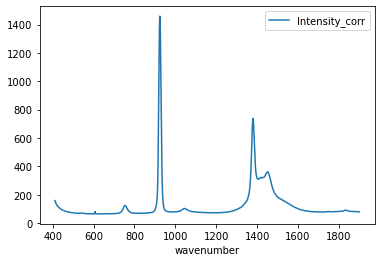

In [166]:
#ploting data
rd2_reset.plot(x ='wavenumber', y='Intensity_corr', kind = 'line')

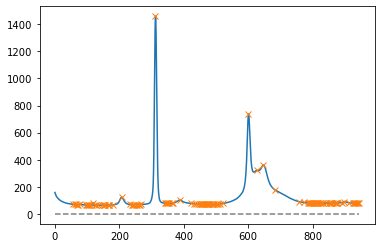

In [167]:
#peak find

rd3 = rd2_reset[["Intensity_corr"]].to_numpy()
rd3 = rd3.flatten()
#rd3
peaks, _ = find_peaks(rd3, height=0)
plt.plot(rd3)
plt.plot(peaks, rd3[peaks], "x")
plt.plot(np.zeros_like(rd3), "--", color="gray")
plt.show()

# Baseline Subtration

Baseline subtraction from the dataset

/Users/nishithmaity/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


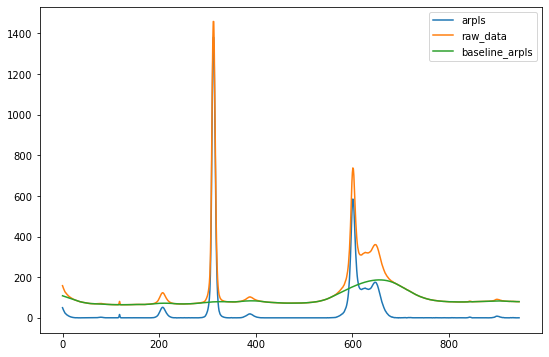

In [168]:
# Baseline subttraction : arpls method


def baseline_arPLS(x, ratio = 1e-6, lam = 150, n_iter = 1000, full_output = False):
    l = len(x)
    diag = np.ones(l - 2)
    D = sparse.spdiags([diag, -2 * diag, diag], [0, -1, -2], l, l - 2)
    H = lam * D.dot(D.T)
    n = np.ones(l)
    sp = sparse.spdiags(n, 0, l, l)
    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(sp + H, sp * x)
        d = x - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)
        n_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))
        crit = norm(n_new - n) / norm(n)

        n = n_new
        sp.setdiag(n) 
        count += 1
        if count > n_iter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        m = {'num_iter': count, 'stop_criterion': crit}
        return z, d, m
    else:
        return z
    
baseline_arpls = baseline_arPLS(rd2_reset['Intensity_corr'])
#baseline_arpls
rd2_reset['Intensity_corr']
intensity_arpls = rd2_reset['Intensity_corr'] - baseline_arpls
#plot baseline subtracted data

plt.figure(figsize=(9, 6))
plt.plot(intensity_arpls, label='arpls')
plt.plot(rd2_reset['Intensity_corr'], label='raw_data')
plt.plot(baseline_arpls, label='baseline_arpls')
plt.legend()


# Save baseline subtracted data

In [169]:
#save baseline subtracted data

intensity_arpls.to_csv(r'/Users/nishithmaity/Desktop/sample_data/ACN_10s_10acc_baseline_subtr.csv', index=False)

# Import both solvent and sample dataset

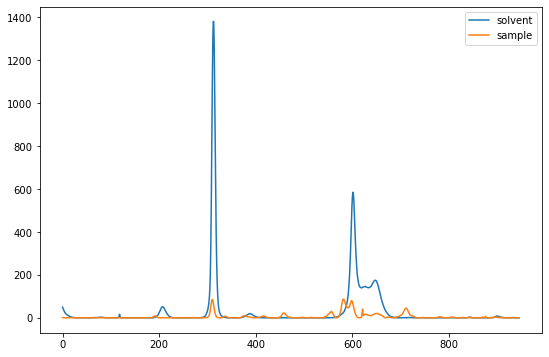

In [170]:
#Import baseline subtracted data and baseline corrected solvent data
#Goal is to plot both solvent and sample in same figure

sd = pd.read_csv (r'/Users/nishithmaity/Desktop/sample_data/ACN_10s_10acc_baseline_subtr.csv')
sd.columns.values[0:1] =["Intensity"]

samp = pd.read_csv (r'/Users/nishithmaity/Desktop/sample_data/samp_10s_10acc_baseline_subtr.csv')
samp.columns.values[0:1] =["Intensity"]

#plot

plt.figure(figsize=(9, 6))
plt.plot(sd, label='solvent')
plt.plot(samp, label='sample')
plt.legend()

#sd.plot((figsize=(12, 9) y='Intensity', kind = 'line', label='solvent')
#intensity_arpls.plot((figsize=(12, 9) y='Intensity', kind = 'line', label='sample')

# Normalize and subtract solvent spectrum from sample

<AxesSubplot:xlabel='wavenumber'>

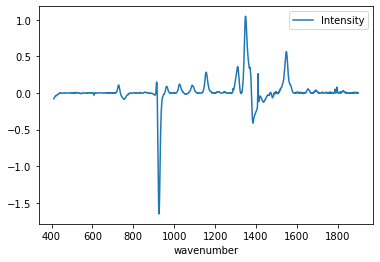

In [171]:
#Find index of maximum of Intensity of one solvent peak so that we can nnoormalize with respect to that value
#to get solvent first both normalized and then solvent subtracted data

sd1=sd/sd[['Intensity']][595:900].max()
samp1=samp/samp[['Intensity']][595:900].max()
solv_subtracted=samp1-sd1
#solv_subtracted

#add wavenumber column to get the final solventt subtracted data
rd4 = rd2_reset.drop('Intensity_corr', axis=1)
rd4 = pd.concat([rd4, solv_subtracted], axis=1)
#rd4 = rd4.dropna()
#rd4
rd4.plot(x ='wavenumber', y='Intensity', kind = 'line')

#plt.figure(figsize=(9, 6))
#plt.plot(solv_subtracted, label='solvent_subtracted')
#plt.legend()

# baseline subtraction one more time after solvent subtraction 

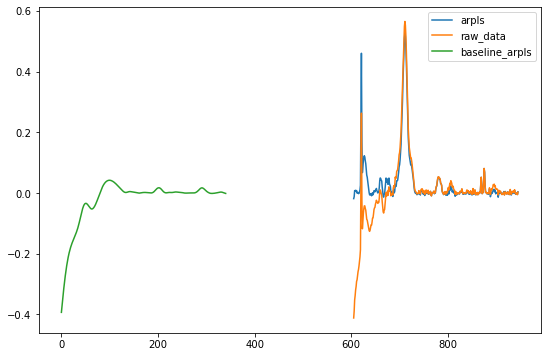

In [172]:

def baseline_arPLS(x, ratio = 1e-6, lam = 150, n_iter = 1000, full_output = False):
    l = len(x)
    diag = np.ones(l - 2)
    D = sparse.spdiags([diag, -2 * diag, diag], [0, -1, -2], l, l - 2)
    H = lam * D.dot(D.T)
    n = np.ones(l)
    sp = sparse.spdiags(n, 0, l, l)
    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(sp + H, sp * x)
        d = x - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)
        n_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))
        crit = norm(n_new - n) / norm(n)

        n = n_new
        sp.setdiag(n) 
        count += 1
        if count > n_iter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        m = {'num_iter': count, 'stop_criterion': crit}
        return z, d, m
    else:
        return z
rd5 = rd4.iloc[605:]  
#rd5_reset = rd5.reset_index(drop = True)
baseline_arpls2 = baseline_arPLS(rd5['Intensity'])
intensity_arpls2 = rd5['Intensity'] - baseline_arpls2
#plot baseline subtracted data

plt.figure(figsize=(9, 6))
plt.plot(intensity_arpls2, label='arpls')
plt.plot(rd5['Intensity'], label='raw_data')
plt.plot(baseline_arpls2, label='baseline_arpls')
plt.legend()
intensity_arpls2 = intensity_arpls2.to_frame()
#type(intensity_arpls2)

# Preparing both baseline and solvent subtracted dataset for saving

<AxesSubplot:xlabel='wavenumber'>

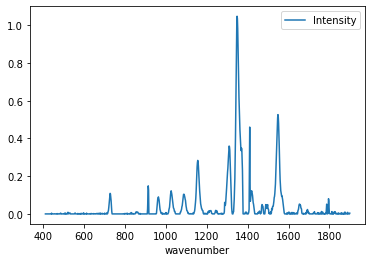

In [173]:
rd6 = rd4.iloc[:605]
rd6 = rd6.drop('wavenumber', axis=1)
#rd6.index = intensity_arpls2.index 
rd7 = pd.concat([rd6, intensity_arpls2], axis = 0)
rd7
rdn = rd4.drop('Intensity', axis=1)
rd8 = pd.concat([rdn, rd7], axis=1)
rd8
for col in rd8.columns:
    rd8[col][rd8[col] < 0] = 0
rd8
rd8.plot(x ='wavenumber', y='Intensity', kind = 'line')

# Save final solvent subtracted data

In [174]:
#save solvent subtracted data

rd8.to_csv(r'/Users/nishithmaity/Desktop/sample_data/samp_10s_10acc_baseline_solv_subtracted.csv', index=False)

# End